# WESAD
###  A Multimodal Dataset for Wearable Stress and Affect Detection

##### Matthew Johnson

--------

##### April 22, 2019

##### May 9, 2019
    ~~DONE: - add datetimes
    
##### May 11-12, 2019
    ~~TODO: - add more feats
            - hrv from bvp, peak detection [1]
            - lowpass eda (5hz) [1]
                - dynamic range?
                Details about the EDA-related features can be found in Choi et al.
                [3] and Healey et al. [6].
            - sub divide folders better
            - (DONE) add features from readme files (gender, weight, height, smoker, etc.)
    - downsampling baseline data didn't help (removed now)
    - added new features from **cvxEDA
    
##### May 13, 2019
    - added patient specific feats (weight, age, height, gender, smoker, etc.)
        - went from .85->.89 acc
    - TODO: 
        - Leave one out cross validation? ( wrt patients )
        - add write up about actual trial (funny videos for amusement, meditation period, etc.)
##### May 14, 2019
    - TODO: 
        - add early stopping
   
[1] Introducing WESAD... (do this)  

[3] J. Choi, B. Ahmed, and R. Gutierrez-Osuna. 2012. Development and evaluation
of an ambulatory stress monitor based on wearable sensors. IEEE Transactions
on Information Technology in Biomedicine 16, 2 (2012).  
    http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf
    
    
[6] J. Healey and **R. Picard.** 2005. Detecting stress during real-world driving tasks
using physiological sensors. IEEE Transactions on Intelligent Transportation
Systems 6, 2 (2005), 156–166.  


#### Useful Resources:
- https://github.com/jaganjag/stress_affect_detection
- https://github.com/arsen-movsesyan/springboard_WESAD
- https://www.birmingham.ac.uk/Documents/college-les/psych/saal/guide-electrodermal-activity.pdf
- http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf
- https://www.researchgate.net/publication/259560204_Is_There_More_to_Blood_Volume_Pulse_Than_Heart_Rate_Variability_Respiratory_Sinus_Arrhythmia_and_Cardiorespiratory_Synchrony

In [1]:
#! python3.6 data_wrangling4.py

## Dataset and Dataloading

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset


class WESADDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.drop('subject', axis=1)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)
        
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].values
        y = self.labels[idx]
        return torch.Tensor(x), y

    def __len__(self):
        return len(self.dataframe)

### Cross Validation Loader

In [3]:
feats =   [
           'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
           'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_phasic_mean',
           'EDA_phasic_std', 'EDA_phasic_min', 'EDA_phasic_max', 'EDA_smna_mean',
           'EDA_smna_std', 'EDA_smna_min', 'EDA_smna_max', 'EDA_tonic_mean',
           'EDA_tonic_std', 'EDA_tonic_min', 'EDA_tonic_max', 'Resp_mean',
           'Resp_std', 'Resp_min', 'Resp_max', 'TEMP_mean', 'TEMP_std', 'TEMP_min',
           'TEMP_max', 'BVP_peak_freq', 'age', 'height',
           'weight','subject', 'label']
len(feats) -2

32

In [4]:
def get_data_loaders(subject_id, train_batch_size=25, test_batch_size=5):
    df = pd.read_csv('m14_merged.csv', index_col=0)#[feats]

    train_df = df[ df['subject'] != subject_id].reset_index(drop=True)
    test_df = df[ df['subject'] == subject_id].reset_index(drop=True)
    
    #print('Training class distribution')
    #print(train_df['label'].value_counts())
    #print('Testing class distribution')
    #print(test_df['label'].value_counts())
    
    train_dset = WESADDataset(train_df)
    test_dset = WESADDataset(test_df)

    train_loader = torch.utils.data.DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dset, batch_size=test_batch_size)
    
    return train_loader, test_loader

## Network Architecture

In [5]:
class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        self.fc = nn.Sequential(
                        nn.Linear(55, 128),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(256, 3),
                        #nn.Dropout(0.5),
                        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.fc(x)    

## Model Training

In [6]:
def train(model, optimizer, train_loader, validation_loader):
    history = {'train_loss': {}, 'train_acc': {}, 'valid_loss': {}, 'valid_acc': {}}
    #
    for epoch in range(num_epochs):

        # Train:   
        total = 0
        correct = 0
        trainlosses = []

        for batch_index, (images, labels) in enumerate(train_loader):

            # Send to GPU (device)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images.float())

            # Loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trainlosses.append(loss.item())

            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)

        history['train_loss'][epoch] = np.mean(trainlosses) 
        history['train_acc'][epoch] = correct/total 

        if epoch % 10 == 0:
            with torch.no_grad():

                losses = []
                total = 0
                correct = 0

                for images, labels in validation_loader:
                    # 
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(images.float())
                    loss = criterion(outputs, labels)

                    # Compute accuracy
                    _, argmax = torch.max(outputs, 1)
                    correct += (labels == argmax).sum().item() #.mean()
                    total += len(labels)

                    losses.append(loss.item())
                    
                history['valid_acc'][epoch] = np.round(correct/total, 3)
                history['valid_loss'][epoch] = np.mean(losses)

                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')
                
    return history

In [7]:
def test(model, validation_loader):
    print('Evaluating model...')
    # Test
    model.eval()

    total = 0
    correct = 0
    testlosses = []
    correct_labels = []
    predictions = []

    with torch.no_grad():

        for batch_index, (images, labels) in enumerate(validation_loader):
            # Send to GPU (device)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images.float())

            # Loss
            loss = criterion(outputs, labels)

            testlosses.append(loss.item())

            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)

            correct_labels.extend(labels)
            predictions.extend(argmax)


    test_loss = np.mean(testlosses)
    accuracy = np.round(correct/total, 2)
    print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')
    
    from sklearn.metrics import confusion_matrix

    y_true = [label.item() for label in correct_labels]
    y_pred = [label.item() for label in predictions]

    cm = confusion_matrix(y_true, y_pred)
    # rows actual, cols pred
    #sns.heatmap(cm, annot=True, fmt='d');
    #plt.xlabel('Prediction');
    #plt.ylabel('Ground Truth');
    return cm, test_loss, accuracy

In [8]:
# Batch sizes
train_batch_size = 25
test_batch_size = 5

# Learning Rate
learning_rate = 5e-3

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of Epochs
num_epochs = 200

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# 
df = pd.read_csv('m14_merged.csv', index_col=0)
subject_id_list = df['subject'].unique()

histories = []
confusion_matrices = []
test_losses = []
test_accs = []

for _ in subject_id_list:
    print('\nSubject: ', _)
    model = StressNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loader, test_loader = get_data_loaders(_)
    
    history = train(model, optimizer, train_loader, test_loader)
    histories.append(history)
    
    cm, test_loss, test_acc = test(model, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    confusion_matrices.append(cm)


Subject:  2
Epoch [1/200], Loss: 1.084, Acc: 0.51
Epoch [11/200], Loss: 0.8032, Acc: 0.75
Epoch [21/200], Loss: 0.8194, Acc: 0.7
Epoch [31/200], Loss: 0.6746, Acc: 0.74
Epoch [41/200], Loss: 0.8523, Acc: 0.76
Epoch [51/200], Loss: 0.9852, Acc: 0.76
Epoch [61/200], Loss: 0.7352, Acc: 0.76
Epoch [71/200], Loss: 0.7748, Acc: 0.78
Epoch [81/200], Loss: 0.6928, Acc: 0.7
Epoch [91/200], Loss: 0.8172, Acc: 0.78
Epoch [101/200], Loss: 0.8394, Acc: 0.78
Epoch [111/200], Loss: 0.8902, Acc: 0.7
Epoch [121/200], Loss: 0.6781, Acc: 0.75
Epoch [131/200], Loss: 0.7342, Acc: 0.75
Epoch [141/200], Loss: 0.8117, Acc: 0.74
Epoch [151/200], Loss: 0.8116, Acc: 0.68
Epoch [161/200], Loss: 0.7255, Acc: 0.75
Epoch [171/200], Loss: 1.025, Acc: 0.62
Epoch [181/200], Loss: 1.159, Acc: 0.63
Epoch [191/200], Loss: 0.8095, Acc: 0.66
Evaluating model...
Loss: 0.7793, Acc: 0.71

Subject:  3
Epoch [1/200], Loss: 1.04, Acc: 0.44
Epoch [11/200], Loss: 1.133, Acc: 0.48
Epoch [21/200], Loss: 1.012, Acc: 0.57
Epoch [31/20

Epoch [121/200], Loss: 0.6994, Acc: 0.68
Epoch [131/200], Loss: 0.8231, Acc: 0.76
Epoch [141/200], Loss: 0.4849, Acc: 0.75
Epoch [151/200], Loss: 0.6922, Acc: 0.71
Epoch [161/200], Loss: 0.6881, Acc: 0.76
Epoch [171/200], Loss: 0.5607, Acc: 0.75
Epoch [181/200], Loss: 0.6751, Acc: 0.66
Epoch [191/200], Loss: 0.4808, Acc: 0.75
Evaluating model...
Loss: 0.4463, Acc: 0.81

Subject:  13
Epoch [1/200], Loss: 1.019, Acc: 0.41
Epoch [11/200], Loss: 0.8592, Acc: 0.7
Epoch [21/200], Loss: 1.476, Acc: 0.63
Epoch [31/200], Loss: 1.006, Acc: 0.68
Epoch [41/200], Loss: 1.379, Acc: 0.68
Epoch [51/200], Loss: 1.853, Acc: 0.65
Epoch [61/200], Loss: 2.676, Acc: 0.46
Epoch [71/200], Loss: 1.628, Acc: 0.57
Epoch [81/200], Loss: 1.779, Acc: 0.58
Epoch [91/200], Loss: 1.24, Acc: 0.7
Epoch [101/200], Loss: 2.079, Acc: 0.59
Epoch [111/200], Loss: 1.716, Acc: 0.63
Epoch [121/200], Loss: 3.562, Acc: 0.62
Epoch [131/200], Loss: 1.89, Acc: 0.66
Epoch [141/200], Loss: 2.208, Acc: 0.49
Epoch [151/200], Loss: 1.636

In [9]:
np.mean(test_accs)

0.7293333333333333

In [10]:
np.mean(test_losses)

1.2181262796322876

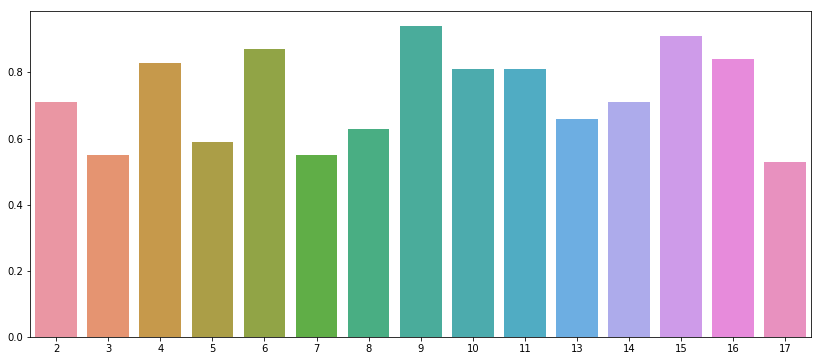

In [11]:
plt.figure(figsize=(14, 6))
sns.barplot(x=subject_id_list, y=test_accs);

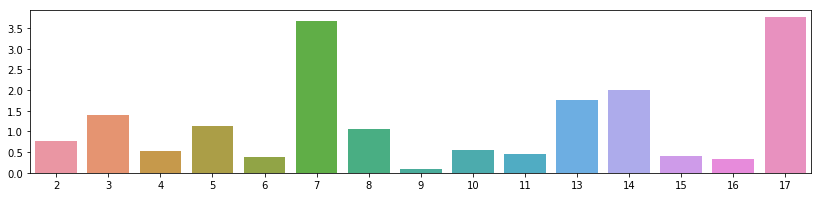

In [12]:
plt.figure(figsize=(14, 3))
sns.barplot(x=subject_id_list, y=test_losses);

In [13]:
infodf = pd.read_csv('data/WESAD/readmes.csv', index_col=0)
infodf.sort_index()

,age,height,weight,gender,dominant_hand,coffee_today,coffee_last_hour,sport_today,smoker,smoke_last_hour,feel_ill_today
S10,28,178,76,male,right,NO,NO,NO,NO,NO,NO
S11,26,171,54,female,right,YES,NO,NO,NO,NO,NO
S13,28,181,82,male,right,NO,NO,NO,NO,NO,NO
S14,27,180,80,male,right,NO,NO,NO,NO,NO,NO
S15,28,186,83,male,right,NO,NO,NO,NO,NO,NO
S16,24,184,69,male,right,NO,NO,NO,NO,NO,NO
S17,29,165,55,female,right,NO,NO,NO,NO,NO,NO
S2,27,175,80,male,right,NO,NO,NO,NO,NO,NO
S3,27,173,69,male,right,NO,NO,NO,NO,NO,NO
S4,25,175,90,male,right,NO,NO,NO,NO,NO,NO


## Training Visualization

In [14]:
len(histories)

15

## Model Evaluation

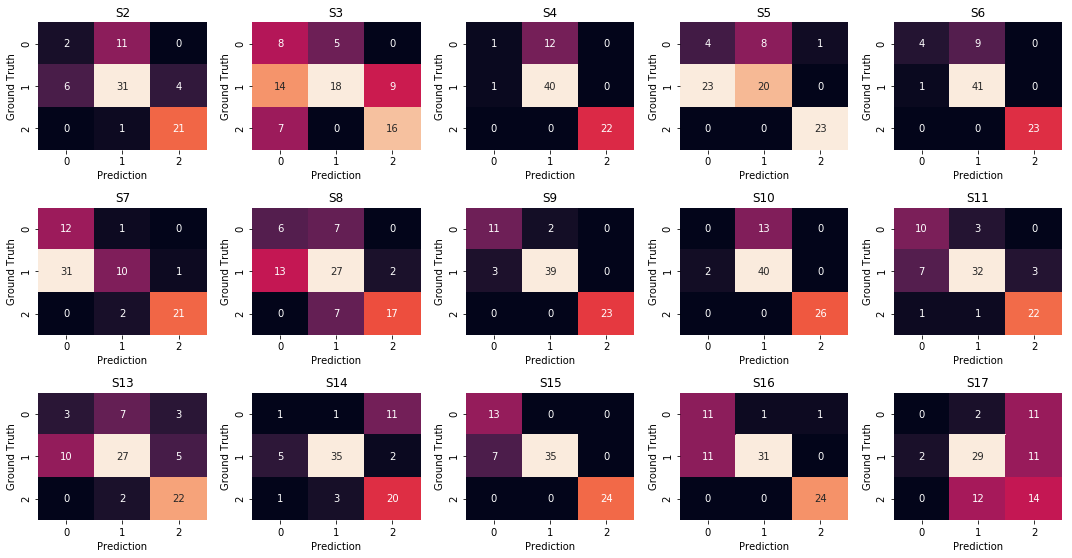

In [15]:
plt.figure(figsize=(15,10))

for i in range(15):
    plt.subplot(4,5 ,i+1)
    cm = confusion_matrices[i]
    
    
    sns.heatmap(cm, annot=True, fmt='d', cbar=False);
    plt.title(f'S{subject_id_list[i]}')
    plt.xlabel('Prediction');
    plt.ylabel('Ground Truth');
plt.tight_layout();

In [16]:
#from sklearn.metrics import classification_report

#target_names = ['Amusement', 'Baseline', 'Stress']
#print(classification_report(y_true, y_pred, target_names=target_names))

In [17]:
#torch.save(model.state_dict(), 'm13_model.pt')